In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 모듈 설치

In [ ]:
# 모델링 모듈
!pip install tensorflow-addons
!pip install neuralprophet[live]
!pip install prophet

In [ ]:
# 폰트설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 모듈 및 라이브러리

In [68]:
# 내장 라이브러리
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# 외장 라이브러리
from typing import collections, List, Tuple, Dict, DefaultDict, NewType
from collections import Counter
from datetime import datetime, timedelta
from timeit import default_timer as timer

# sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Facebook Prophet - 시계열 모델
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_yearly
# Neural Prophet - Advanced Facebook Prophet
from neuralprophet import NeuralProphet
# 시계열 모델
from statsmodels.tsa.arima_model import ARIMA
# Attention 모델
import keras
from tensorflow_addons.layers import MultiHeadAttention

In [69]:
# plot 한글
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':# 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

elif platform.system() == 'Linux': # colab 사용자의 경우에
  # 나눔고딕 폰트
  plt.rc('font', family='NanumBarunGothic') 


# 데이터 로드

In [79]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기
os.chdir('/content/drive/MyDrive/BIGCONTEST/data/real_use')

name = input('수산물 어종을 고르세요 (오징어/흰다리새우/연어)')

if name == "오징어":
  data = pd.read_csv("./squid_temp1.csv")
  val_df = pd.read_csv("./squid_temp2.csv")
elif name == "흰다리새우":
  data = pd.read_csv("./shrimp_temp1.csv")
  val_df = pd.read_csv("./shrimp_temp2.csv")
elif name == "연어":
  data = pd.read_csv("./salmon_temp1.csv")
  val_df = pd.read_csv("./salmon_temp2.csv")
else:
  None

수산물 어종을 고르세요 (오징어/흰다리새우/연어)흰다리새우


In [80]:
# 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(data, p_name):

  just_p = pd.DataFrame(columns=data.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(data['REG_DATE']).keys())):
    day_df = data[data['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))

  return just_p, len_list

In [81]:
# import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [82]:
train, t_len = datasetting(data, name)
validation, v_len = datasetting(val_df, name)

In [83]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [84]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [85]:
x_train = data_frame(train, ctry_list)

In [86]:
x_val = data_frame(validation, ctry_list)

# 학습, 테스트 데이터 분리 

In [87]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [88]:
X_val = np.array(x_val.iloc[:,:-1])
Y_val = np.array(x_val.iloc[:,-1])
Y_val = Y_val.reshape(-1)

In [89]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1613, 20), (1613,), (287, 20), (287,))

In [90]:
num_heads=8; head_size=32; ff_dim=None; dropout=0

multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [91]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [92]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=2, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [93]:
# Attention 계산 및 FC layer 차원축소 
attention_layers = ModelTrunk()

In [94]:
# 소프트맥스 함수 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [95]:
# Attention - FC layer 를 통한 가중치 리스트와 가격 리스트 생성
def make_weight(x, y,length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        weight_score.append(np.array(softmax(arr)).tolist()) ## attention score를 softmax 함수를 이용해서 정규화
        p_price.append(b)
        before += leng

    for w in weight_score:
        aa = sum(w, [])
        final_weight.append(aa)

    return final_weight,p_price

In [96]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)

In [97]:
val_weight, val_price = make_weight(X_val, Y_val,v_len)

In [98]:
# 가중치를 이용한 새로운 가격 변수 생성
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

In [99]:
# attention score의 가중치를 적용한 가중평균 
train_price = make_new_price(train_weight, train_price)

In [100]:
val_price = make_new_price(val_weight, val_price)

In [101]:
trn_lst = np.array([item for item in train_price if item > 0])

In [102]:
train['REG_DATE'] = pd.to_datetime(train['REG_DATE'])
validation['REG_DATE'] = pd.to_datetime(validation['REG_DATE'])

In [103]:
# 가중평균한 최종 가격 배열로 만들기 
ts_train = np.array(train_price)

# RMSE 함수 (평가지표)

In [104]:
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

- validation y : val_price


# Neural Prophet - normal

In [105]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(197, 2)


In [106]:
val_date = list(validation['REG_DATE'].unique())

In [107]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 
epochs = 1000

In [108]:
# 모델 학습
m = NeuralProphet()
metrics = m.fit(df, freq =freq,
                epochs=epochs)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:44<00:00, 22.69it/s, SmoothL1Loss=0.000401, MAE=0.0307, RegLoss=0]


In [109]:
# 예측 기간 데이터셋 생성
val_date = list(validation['REG_DATE'].unique())
future = pd.DataFrame(val_date, columns=['ds'])
future['y'] = None

In [110]:
# train 데이터의 마지막일 기준으로, 일주일 간격 * 70 의 테스트데이터 생성
future = m.make_future_dataframe(df, periods=70)
forecast = m.predict(future)

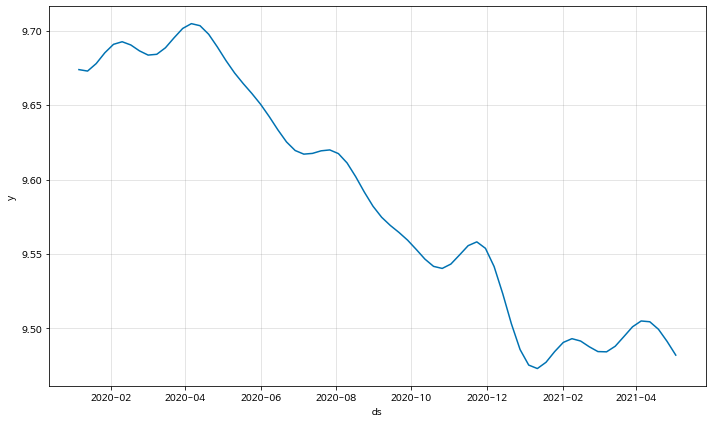

In [111]:
forecasts_plot = m.plot(forecast)

In [112]:
# validation 기간에 맞는 예측 데이터 프레임 구성
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [113]:
# rmse
rmse(val_price, a['yhat1'])

0.45482956734039054

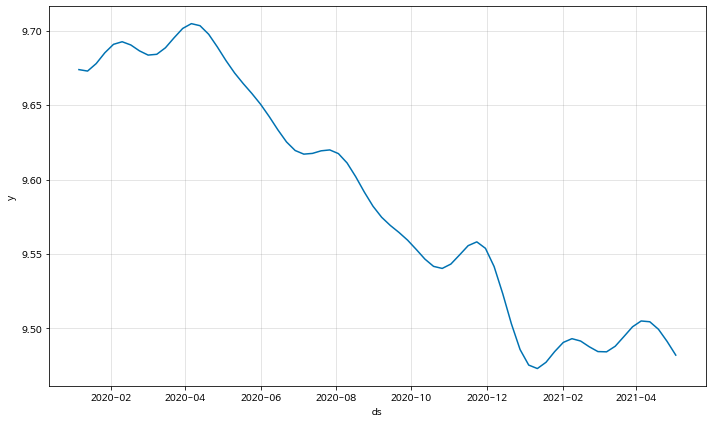

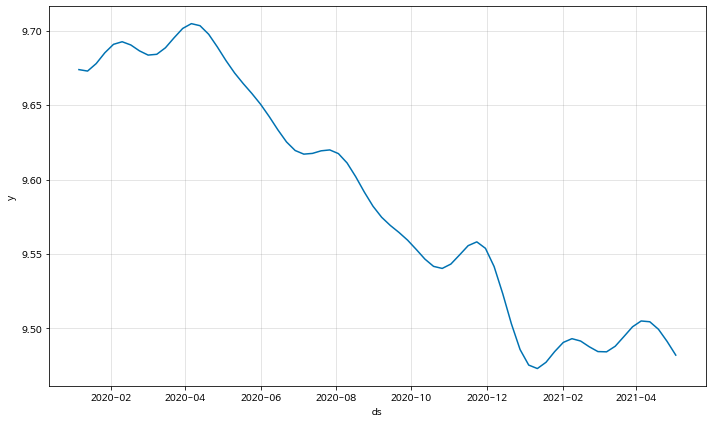

In [115]:
m.plot(forecast)

# Neural Prophet - Trend

In [ ]:
m = NeuralProphet(
    n_changepoints=100,
    #trend_smoothness=2,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs =epochs
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:37<00:00, 26.59it/s, SmoothL1Loss=0.000187, MAE=0.0151, RegLoss=0]


In [ ]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(val_price, a['yhat1'])

0.4773086533393265

# Nueral Prophet - Seasonality

In [ ]:
m = NeuralProphet(
    n_changepoints=200,
    yearly_seasonality=15,
    weekly_seasonality=3,
    seasonality_reg=30,
    num_hidden_layers=20,
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 162


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
Epoch[162/162]: 100%|██████████| 162/162 [00:08<00:00, 18.13it/s, SmoothL1Loss=0.000258, MAE=0.0186, RegLoss=4.33e-5]


In [ ]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(val_price, a['yhat1'])

0.47643042900295485

# 최적 하이퍼 파라미터


In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

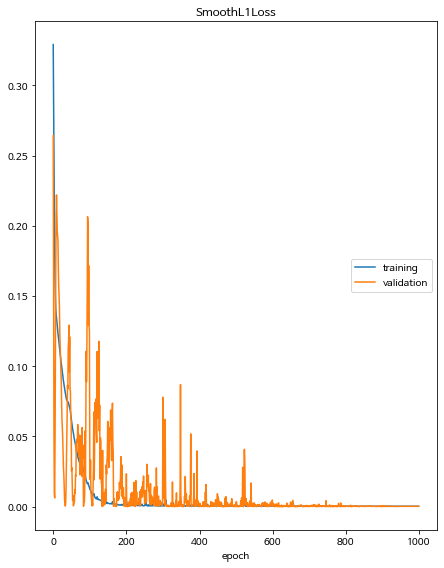

Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:56<00:00, 17.84it/s, SmoothL1Loss=0.000319, MAE=0.0191, RegLoss=0.000391, MAE_val=0.0485, SmoothL1Loss_val=0.000287]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
forecast.tail()

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
244,2020-11-30,NaN,10.340155,NaN,10.340155,1.438495e-09,-1.053066e-07
245,2020-12-07,NaN,10.341570,NaN,10.341570,1.438495e-09,-1.053066e-07
246,2020-12-14,NaN,10.342986,NaN,10.342986,1.438495e-09,-1.053066e-07
247,2020-12-21,NaN,10.344402,NaN,10.344402,1.438495e-09,-1.053066e-07
248,2020-12-28,NaN,10.345818,NaN,10.345818,1.438495e-09,-1.053066e-07


In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
rmse(val_price, a['yhat1'])

0.4675106640389403

# 최적 하이퍼 파라미터 ver.2

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.01


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

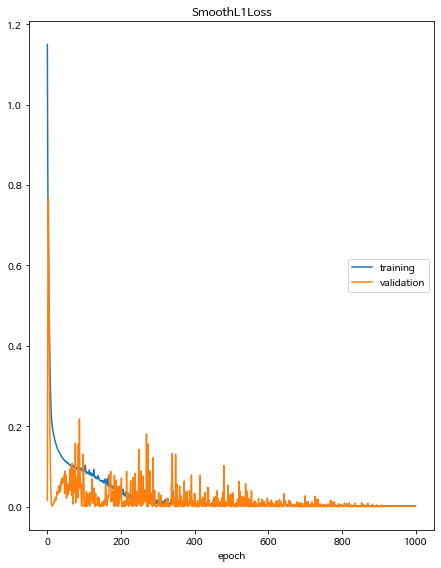

Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:56<00:00, 17.80it/s, SmoothL1Loss=0.0019, MAE=0.0691, RegLoss=0.311, MAE_val=0.0997, SmoothL1Loss_val=0.00117]


In [ ]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [ ]:
future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)

,ds,y,yhat1,trend
244,2020-11-30,NaN,10.554707,-67.926414
245,2020-12-07,NaN,10.558991,-68.067780
246,2020-12-14,NaN,10.563269,-68.209137
247,2020-12-21,NaN,10.567554,-68.350502
248,2020-12-28,NaN,10.571839,-68.491867


In [ ]:
# validation 날짜와 맞는 데이터 추출하기 위한 데이터 프레임
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])

for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)
rmse(val_price, a['yhat1'])

0.47151938729457143

# 최적 하이퍼 파라미터 ver.3

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = [0.005, 0.01, 0.015]


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = [10,20,30] # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = [100, 150, 200] # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
# 파라미터별 rmse 저장할 데이터 프레임 생성 
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
# 데이터 프레임 row index 변수 생성
count=0
# 파라미터 조합 반복문 실행
for lr in learning_rate:
  for layer in num_hidden_layers:
    start = timer()
    for changepoint in n_changepoints:

      nprophet = NeuralProphet(
                                yearly_seasonality=False, 
                                weekly_seasonality=True, 
                                daily_seasonality=True,
                                learning_rate=lr, 
                                changepoints_range=changepoints_range, 
                                n_forecasts=n_forecasts,
                                ar_sparsity=ar_sparsity, 
                                n_changepoints=changepoint, 
                                growth='logistic', 
                                seasonality_mode='multiplicative', 
                                trend_reg=trend_reg,
                                num_hidden_layers=layer,
                                seasonality_reg = seasonality_reg)
      
      nprophet.fit(df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
      #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
      future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
      forecast = nprophet.predict(future)
      a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
      for i in val_date:
        a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
      a.reset_index(drop=True, inplace = True)
      result.loc[count] = lr, layer, changepoint, rmse(val_price, a['yhat1'])
      count += 1
      end = timer()
      print(end-start)

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.98it/s, SmoothL1Loss=0.000362, MAE=0.0224, RegLoss=0.000377, MAE_val=0.0567, SmoothL1Loss_val=0.00039]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.933971294


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.90it/s, SmoothL1Loss=0.000353, MAE=0.0214, RegLoss=0.000396, MAE_val=0.0516, SmoothL1Loss_val=0.000323]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


106.07806996299996


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.06it/s, SmoothL1Loss=0.000324, MAE=0.0196, RegLoss=0.000385, MAE_val=0.0453, SmoothL1Loss_val=0.000251]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


158.7692674079999


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s, SmoothL1Loss=0.00191, MAE=0.0713, RegLoss=0.311, MAE_val=0.113, SmoothL1Loss_val=0.00149]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.025409602999844


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.96it/s, SmoothL1Loss=0.000386, MAE=0.0235, RegLoss=0.000466, MAE_val=0.0521, SmoothL1Loss_val=0.000328]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


105.02423975199986


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.87it/s, SmoothL1Loss=0.00195, MAE=0.0717, RegLoss=0.311, MAE_val=0.101, SmoothL1Loss_val=0.0012]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


158.22784341800002


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.19it/s, SmoothL1Loss=0.000383, MAE=0.0229, RegLoss=0.000409, MAE_val=0.0543, SmoothL1Loss_val=0.000358]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.32066238900006


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.15it/s, SmoothL1Loss=0.000392, MAE=0.0237, RegLoss=0.000494, MAE_val=0.0469, SmoothL1Loss_val=0.000267]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


104.76735418700014


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.20it/s, SmoothL1Loss=0.000355, MAE=0.021, RegLoss=0.000442, MAE_val=0.0423, SmoothL1Loss_val=0.00022]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


157.06882887300003


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.27it/s, SmoothL1Loss=0.00205, MAE=0.0747, RegLoss=0.311, MAE_val=0.111, SmoothL1Loss_val=0.00144]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.14204595900014


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.21it/s, SmoothL1Loss=0.00186, MAE=0.0687, RegLoss=0.31, MAE_val=0.101, SmoothL1Loss_val=0.0012]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


104.42290021600002


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.97it/s, SmoothL1Loss=0.00192, MAE=0.0702, RegLoss=0.311, MAE_val=0.101, SmoothL1Loss_val=0.00119]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


157.37273146200005


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.94it/s, SmoothL1Loss=0.000363, MAE=0.0209, RegLoss=0.000358, MAE_val=0.0382, SmoothL1Loss_val=0.000182]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


53.035092150999844


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s, SmoothL1Loss=0.000364, MAE=0.0211, RegLoss=0.000404, MAE_val=0.0504, SmoothL1Loss_val=0.00031]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


106.01828134599987


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.01it/s, SmoothL1Loss=0.000359, MAE=0.0206, RegLoss=0.00039, MAE_val=0.057, SmoothL1Loss_val=0.000394]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


158.84323250199986


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.99it/s, SmoothL1Loss=0.00187, MAE=0.0693, RegLoss=0.311, MAE_val=0.0991, SmoothL1Loss_val=0.00116]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.895757468000056


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:53<00:00, 18.78it/s, SmoothL1Loss=0.00185, MAE=0.0684, RegLoss=0.31, MAE_val=0.0986, SmoothL1Loss_val=0.00115]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


106.37130369300007


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.04it/s, SmoothL1Loss=0.00202, MAE=0.0724, RegLoss=0.311, MAE_val=0.101, SmoothL1Loss_val=0.00119]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


159.12872367399996


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.00it/s, SmoothL1Loss=0.000368, MAE=0.0208, RegLoss=0.000337, MAE_val=0.0489, SmoothL1Loss_val=0.000291]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.86190606900004


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.01it/s, SmoothL1Loss=0.000371, MAE=0.0211, RegLoss=0.000367, MAE_val=0.0478, SmoothL1Loss_val=0.000278]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


105.67323825000017


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.99it/s, SmoothL1Loss=0.00194, MAE=0.0713, RegLoss=0.311, MAE_val=0.0972, SmoothL1Loss_val=0.00111]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


158.55150319300014


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.09it/s, SmoothL1Loss=0.000368, MAE=0.0213, RegLoss=0.000335, MAE_val=0.0512, SmoothL1Loss_val=0.000318]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.59313934299985


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.12it/s, SmoothL1Loss=0.0019, MAE=0.0698, RegLoss=0.311, MAE_val=0.103, SmoothL1Loss_val=0.00123]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


105.10876235799992


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.04it/s, SmoothL1Loss=0.00193, MAE=0.0699, RegLoss=0.311, MAE_val=0.0985, SmoothL1Loss_val=0.00114]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


157.85193365300006


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.12it/s, SmoothL1Loss=0.000363, MAE=0.0209, RegLoss=0.000334, MAE_val=0.0426, SmoothL1Loss_val=0.000224]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.51756186700004


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.13it/s, SmoothL1Loss=0.000359, MAE=0.0206, RegLoss=0.000341, MAE_val=0.044, SmoothL1Loss_val=0.000239]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


105.01615797100021


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.02it/s, SmoothL1Loss=0.00036, MAE=0.0207, RegLoss=0.000382, MAE_val=0.059, SmoothL1Loss_val=0.000425]


157.80897221900022


In [ ]:
result.sort_values(by='rmse', ascending=True)

,learning_rate,num_hidden_layers,n_changepoints,rmse
26,0.015,30.0,200.0,0.461858
14,0.010,20.0,200.0,0.463428
0,0.005,10.0,100.0,0.463438
6,0.005,30.0,100.0,0.464123
1,0.005,10.0,150.0,0.465795
4,0.005,20.0,150.0,0.466068
13,0.010,20.0,150.0,0.466122
21,0.015,20.0,100.0,0.466126
18,0.015,10.0,100.0,0.467634
19,0.015,10.0,150.0,0.467869


# 흰다리 새우 데이터 (수온데이터 제거하고 학습)

In [ ]:
train, t_len = datasetting(data, name)
validation, v_len = datasetting(val_df, name)

In [ ]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [ ]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [ ]:
x_train = data_frame(train, ctry_list)
x_val = data_frame(validation, ctry_list)

In [ ]:
# 마지막 컬럼인 수온데이터를 제거하고 데이터 세팅
x_train = x_train.drop(['temp'], axis=1)
x_val = x_val.drop(['temp'],axis=1)

In [ ]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [ ]:
X_val = np.array(x_val.iloc[:,:-1])
Y_val = np.array(x_val.iloc[:,-1])
Y_val = Y_val.reshape(-1)

In [ ]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1613, 19), (1613,), (287, 19), (287,))

In [ ]:
num_heads=8; head_size=32; ff_dim=None; dropout=0

multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [ ]:
# Attention 계산 및 FC layer 차원축소 
attention_layers = ModelTrunk()

In [ ]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)
val_weight, val_price = make_weight(X_val, Y_val,v_len)

In [ ]:
# attention score의 가중치를 적용한 가중평균 
train_price = make_new_price(train_weight, train_price)

In [ ]:
val_price = make_new_price(val_weight, val_price)

In [ ]:
trn_lst = np.array([item for item in train_price if item > 0])

In [ ]:
train['REG_DATE'] = pd.to_datetime(train['REG_DATE'])
validation['REG_DATE'] = pd.to_datetime(validation['REG_DATE'])

In [ ]:
# 가중평균한 최종 가격 배열로 만들기 
ts_train = np.array(train_price)

## Neural Prophet - normal

In [ ]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(197, 2)


In [ ]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 
epochs = 1000

In [ ]:
# 모델 학습
m = NeuralProphet()
metrics = m.fit(df, freq =freq,
                epochs=epochs)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:42<00:00, 23.41it/s, SmoothL1Loss=0.000251, MAE=0.0279, RegLoss=0]


In [ ]:
# 예측 기간 데이터셋 생성
val_date = list(validation['REG_DATE'].unique())
future = pd.DataFrame(val_date, columns=['ds'])
future['y'] = None

In [ ]:
# train 데이터의 마지막일 기준으로, 일주일 간격 * 70 의 테스트데이터 생성
future = m.make_future_dataframe(df, periods=70)
forecast = m.predict(future)

In [ ]:
# validation 기간에 맞는 예측 데이터 프레임 구성
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(val_price, a['yhat1'])

0.7637432991629397

## Nueral Prophet - Trend

In [ ]:
m = NeuralProphet(
    n_changepoints=100,
    #trend_smoothness=2,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs =epochs
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:36<00:00, 27.25it/s, SmoothL1Loss=0.000123, MAE=0.014, RegLoss=0]


In [ ]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(val_price, a['yhat1'])

0.7819059953841802

## Neural Prophet - Seasonality

In [ ]:
m = NeuralProphet(
    n_changepoints=200,
    yearly_seasonality=15,
    weekly_seasonality=3,
    seasonality_reg=30,
    num_hidden_layers=20,
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 162


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
Epoch[162/162]: 100%|██████████| 162/162 [00:08<00:00, 18.71it/s, SmoothL1Loss=0.000427, MAE=0.0305, RegLoss=0.000173]


In [ ]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)

In [ ]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [ ]:
# rmse
rmse(val_price, a['yhat1'])

0.7821292668358715

## 최적의 하이퍼 파라미터 

In [ ]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = [0.005, 0.01, 0.015]


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = [10,20,30] # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = [100, 150, 200] # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [ ]:
# 파라미터별 rmse 저장할 데이터 프레임 생성 
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
# 데이터 프레임 row index 변수 생성
count=0
# 파라미터 조합 반복문 실행
for lr in learning_rate:
  for layer in num_hidden_layers:
    start = timer()
    for changepoint in n_changepoints:

      nprophet = NeuralProphet(
                                yearly_seasonality=False, 
                                weekly_seasonality=True, 
                                daily_seasonality=True,
                                learning_rate=lr, 
                                changepoints_range=changepoints_range, 
                                n_forecasts=n_forecasts,
                                ar_sparsity=ar_sparsity, 
                                n_changepoints=changepoint, 
                                growth='logistic', 
                                seasonality_mode='multiplicative', 
                                trend_reg=trend_reg,
                                num_hidden_layers=layer,
                                seasonality_reg = seasonality_reg)
      
      nprophet.fit(df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
      #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
      future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
      forecast = nprophet.predict(future)
      a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
      for i in val_date:
        a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
      a.reset_index(drop=True, inplace = True)
      result.loc[count] = lr, layer, changepoint, rmse(val_price, a['yhat1'])
      count += 1
      end = timer()
      print(end-start)

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.20it/s, SmoothL1Loss=0.0003, MAE=0.0256, RegLoss=0.000527, MAE_val=0.0198, SmoothL1Loss_val=6.35e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.31398769500083


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s, SmoothL1Loss=0.00229, MAE=0.0932, RegLoss=0.313, MAE_val=0.0305, SmoothL1Loss_val=8.38e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


105.31757364600071


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.99it/s, SmoothL1Loss=0.000302, MAE=0.0255, RegLoss=0.000636, MAE_val=0.0292, SmoothL1Loss_val=0.000111]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


158.2087564910007


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.09it/s, SmoothL1Loss=0.000328, MAE=0.0286, RegLoss=0.000556, MAE_val=0.0117, SmoothL1Loss_val=2.58e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.61185041599947


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.39it/s, SmoothL1Loss=0.00227, MAE=0.093, RegLoss=0.312, MAE_val=0.0392, SmoothL1Loss_val=0.000133]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


104.41194529099994


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s, SmoothL1Loss=0.000273, MAE=0.0238, RegLoss=0.000532, MAE_val=0.0341, SmoothL1Loss_val=0.000147]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


157.41388768999968


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.12it/s, SmoothL1Loss=0.0024, MAE=0.099, RegLoss=0.313, MAE_val=0.0142, SmoothL1Loss_val=3.49e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.53237240500039


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.20it/s, SmoothL1Loss=0.000352, MAE=0.0293, RegLoss=0.000671, MAE_val=0.0533, SmoothL1Loss_val=0.000324]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


104.84074826699998


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.37it/s, SmoothL1Loss=0.000274, MAE=0.0234, RegLoss=0.000574, MAE_val=0.0531, SmoothL1Loss_val=0.000316]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


156.6899208089999


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.30it/s, SmoothL1Loss=0.000307, MAE=0.0246, RegLoss=0.0005, MAE_val=0.0276, SmoothL1Loss_val=0.000104]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.048157049999645


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.17it/s, SmoothL1Loss=0.00029, MAE=0.024, RegLoss=0.000479, MAE_val=0.0257, SmoothL1Loss_val=9.1e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


104.4580100029998


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.13it/s, SmoothL1Loss=0.00209, MAE=0.0856, RegLoss=0.312, MAE_val=0.0205, SmoothL1Loss_val=3.99e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


156.96959106099985


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.34it/s, SmoothL1Loss=0.000314, MAE=0.0258, RegLoss=0.00051, MAE_val=0.0254, SmoothL1Loss_val=9.34e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


51.942779846999656


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.22it/s, SmoothL1Loss=0.000307, MAE=0.0245, RegLoss=0.000528, MAE_val=0.023, SmoothL1Loss_val=7.77e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


104.22925159100032


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.27it/s, SmoothL1Loss=0.000305, MAE=0.0246, RegLoss=0.000562, MAE_val=0.048, SmoothL1Loss_val=0.000262]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


156.34098659499978


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.49it/s, SmoothL1Loss=0.00221, MAE=0.0895, RegLoss=0.312, MAE_val=0.0151, SmoothL1Loss_val=2.33e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


51.535134149999976


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.46it/s, SmoothL1Loss=0.00215, MAE=0.0873, RegLoss=0.312, MAE_val=0.0176, SmoothL1Loss_val=2.93e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


103.16767022800013


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.09it/s, SmoothL1Loss=0.000304, MAE=0.0241, RegLoss=0.000513, MAE_val=0.0209, SmoothL1Loss_val=6.84e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


155.76870597300058


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.26it/s, SmoothL1Loss=0.00226, MAE=0.0887, RegLoss=0.312, MAE_val=0.0165, SmoothL1Loss_val=2.59e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.15405779400044


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.20it/s, SmoothL1Loss=0.00032, MAE=0.025, RegLoss=0.000451, MAE_val=0.0178, SmoothL1Loss_val=5.3e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


104.45173610700022


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:53<00:00, 18.84it/s, SmoothL1Loss=0.000301, MAE=0.0242, RegLoss=0.000488, MAE_val=0.0131, SmoothL1Loss_val=3.3e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


157.7537819170002


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:53<00:00, 18.83it/s, SmoothL1Loss=0.000318, MAE=0.0249, RegLoss=0.000473, MAE_val=0.0285, SmoothL1Loss_val=0.00011]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


53.33806069000002


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s, SmoothL1Loss=0.000287, MAE=0.0234, RegLoss=0.000448, MAE_val=0.013, SmoothL1Loss_val=3.2e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


107.31490037799995


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:53<00:00, 18.52it/s, SmoothL1Loss=0.000311, MAE=0.0246, RegLoss=0.000488, MAE_val=0.011, SmoothL1Loss_val=1.97e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


161.53015108599993


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 19.06it/s, SmoothL1Loss=0.00228, MAE=0.0899, RegLoss=0.312, MAE_val=0.0185, SmoothL1Loss_val=3.27e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


52.686289076999856


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.98it/s, SmoothL1Loss=0.000329, MAE=0.0253, RegLoss=0.000507, MAE_val=0.0258, SmoothL1Loss_val=9.57e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


105.58343607499955


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:52<00:00, 18.90it/s, SmoothL1Loss=0.00031, MAE=0.0245, RegLoss=0.000485, MAE_val=0.0194, SmoothL1Loss_val=6.07e-5]


158.713788303


In [ ]:
result.sort_values(by='rmse', ascending=True)

,learning_rate,num_hidden_layers,n_changepoints,rmse
4,0.005,20.0,150.0,0.759025
1,0.005,10.0,150.0,0.767384
11,0.010,10.0,200.0,0.779051
24,0.015,30.0,100.0,0.781922
18,0.015,10.0,100.0,0.785956
16,0.010,30.0,150.0,0.786782
23,0.015,20.0,200.0,0.789685
15,0.010,30.0,100.0,0.791970
3,0.005,20.0,100.0,0.799375
22,0.015,20.0,150.0,0.800322


- 위의 두 가지 실험을 비교해본 결과 (수온데이터 포함 실험 vs 수온데이터 미포함 실험)

- 수온 데이터를 사용하여 모델을 훈련시키는 것이 성능이 월등히 좋음을 알 수 있음 

# 최적 하이퍼파라미터 적용(10회 실험)

In [116]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.01


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [117]:
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
count = 0
for king in range(10):
  nprophet = NeuralProphet(
                            yearly_seasonality=False, 
                            weekly_seasonality=True, 
                            daily_seasonality=True,
                            learning_rate=learning_rate, 
                            changepoints_range=changepoints_range, 
                            n_forecasts=n_forecasts,
                            ar_sparsity=ar_sparsity, 
                            n_changepoints=n_changepoints, 
                            growth='logistic', 
                            seasonality_mode='multiplicative', 
                            trend_reg=trend_reg,
                            num_hidden_layers=num_hidden_layers,
                            seasonality_reg = seasonality_reg)

  nprophet.fit(df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
  #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
  future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
  forecast = nprophet.predict(future)
  a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
  for i in val_date:
    a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
  a.reset_index(drop=True, inplace = True)
  result.loc[count] = learning_rate, num_hidden_layers, n_changepoints, rmse(val_price, a['yhat1'])
  count += 1

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:53<00:00, 18.61it/s, SmoothL1Loss=0.000424, MAE=0.0245, RegLoss=0.000547, MAE_val=0.00977, SmoothL1Loss_val=2.82e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:53<00:00, 18.58it/s, SmoothL1Loss=0.00245, MAE=0.0824, RegLoss=0.313,

In [118]:
result.sort_values(by='rmse')

,learning_rate,num_hidden_layers,n_changepoints,rmse
7,0.01,20.0,200.0,0.458002
0,0.01,20.0,200.0,0.458004
8,0.01,20.0,200.0,0.458077
6,0.01,20.0,200.0,0.458414
3,0.01,20.0,200.0,0.459516
9,0.01,20.0,200.0,0.459595
5,0.01,20.0,200.0,0.465559
2,0.01,20.0,200.0,0.467713
4,0.01,20.0,200.0,0.468426
1,0.01,20.0,200.0,0.469150


In [119]:
np.mean(result['rmse'].values)

0.4622456817359092

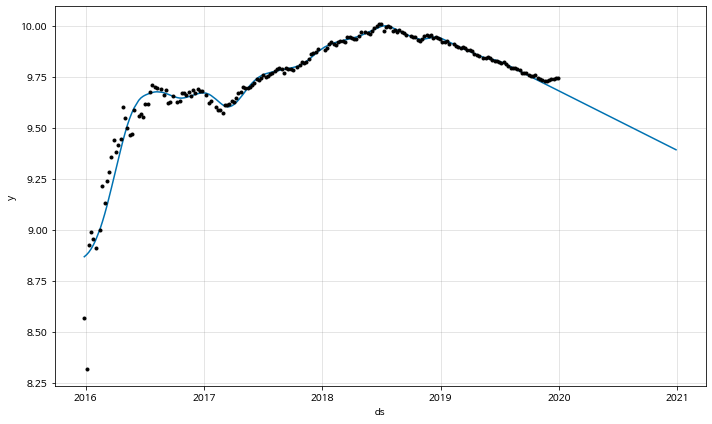

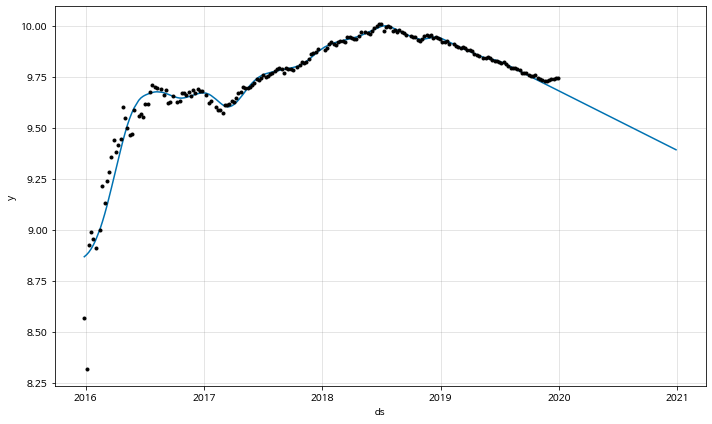

In [120]:
nprophet.plot(forecast)